# <center>House Prices - Advanced Regression Techniques</center>
===========================================================================================================================================
<p align="right"><center>王鑫轶 大数据2001</center></p>

# 一、数据预览

## 1.1 导入相关库

In [52]:
# 导入数据分析的相关库
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns #画图
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,LeaveOneOut
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings # 该库可以忽略警告
warnings.filterwarnings('ignore')

## 1.2 导入数据

In [53]:
# 导入数据集
path='house-prices-advanced-regression-techniques/'
train_data=pd.read_csv(path+'train.csv',index_col='Id')
test_data=pd.read_csv(path+'test.csv',index_col='Id')
# 查看数据集的大小
print("train_data size is {} ".format(train_data.shape))
print("test_data size is {} ".format(test_data.shape))

train_data size is (1460, 80) 
test_data size is (1459, 79) 


查看数据各列的信息

In [54]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# 二、数据预处理

因为训练集和测试集的数据大小基本相同，这里将数据集和测试集数据合并之后再进行数据预处理和特征值分析。

In [55]:
all_data=pd.concat([train_data,test_data])# 合并测试机和训练集
train_num=train_data.shape[0] # 存储训练集的列数

## 2.1 缺失值处理

In [56]:
# 查看缺失值并排序
aa=all_data.isnull().sum()
aa[aa>0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

在看完data_description.txt就知道有些列的缺失值其实是代表着一些意义的，比如'Alley'列的NA就代表着这个住宅没有Alley。所以对于这类的缺失值可以用'None'来填充。

In [57]:
list1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in list1:
    all_data[col].fillna("None", inplace=True)

而有些特征的特征值为数值型，缺失值表示没有改属性。比如'TotalBsmtSF'表示地下室的面积，如果有些房子没有地下室，就将缺失值用0填充。所以下面就将类似的特征用此方法进行缺失值填充。

In [58]:
list2=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea","BsmtFullBath","BsmtHalfBath"]
for col in list2:
    all_data[col].fillna(0, inplace=True)

在data_description.txt中说明'Functional'特征的默认值为'Typ'。

所以该列的缺失值用'Typ'填充。

In [59]:
all_data['Functional'].fillna('Typ',inplace=True)

此为对于一些只有少量的缺失值的离散型特征，用众数填充缺失值。

In [60]:
list3=['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
for col in list3:
    all_data[col].fillna(all_data[col].mode()[0],inplace=True)

In [61]:
all_data['Utilities'].describe()

count       2917
unique         2
top       AllPub
freq        2916
Name: Utilities, dtype: object

由此看出该特征的其中一个特征值的数量远远大于另一个特征值，因此该特征的方差几乎可以忽略不记。所以将该特征删去。

In [62]:
all_data.drop(['Utilities'],axis=1,inplace=True)# 删除该特征

对于'lotFrontage'特征，该特征与'Neighborhood'的特征相近，所以'lotFrontage'的缺失值用各个房子所在Neighborhood的LotFrontage的中位数作为填充值。

In [63]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [64]:
aa=all_data.isnull().sum()# 查看缺失值
aa[aa>0].sort_values(ascending=False) # 对缺失的数量进行降序排序

SalePrice    1459
dtype: int64

In [ ]:
# 将要预测的列单独拿出,并删除
SalePrice=train_data['SalePrice']
all_data.drop(['SalePrice'],axis=1,inplace=True)

到这之后，缺失值填充结束

## 2.2 相关性分析

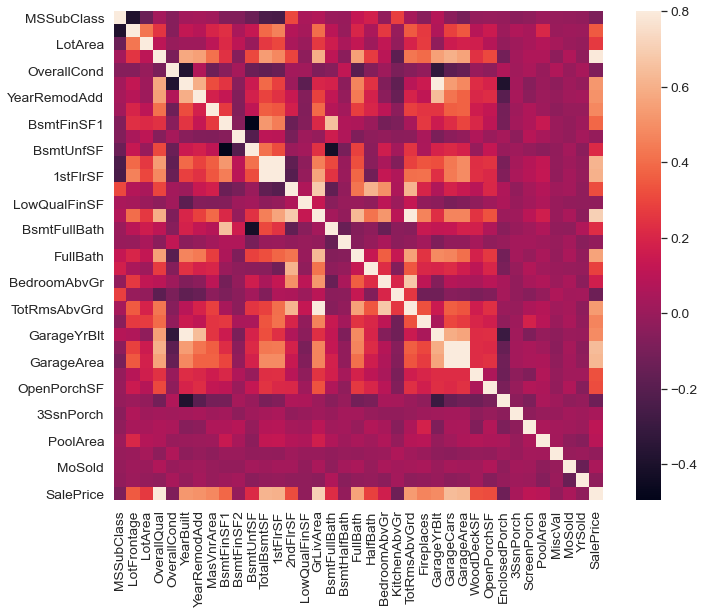

In [65]:
# 画出相关系数的热力图
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, ax=ax)  # square参数保证corrmat为非方阵时，图形整体输出仍为正方形
plt.show()

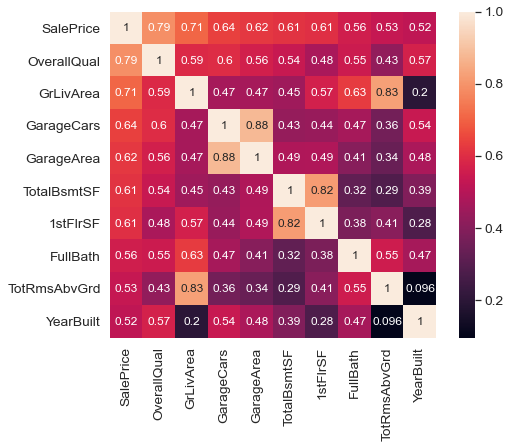

In [66]:
k = 10
top10_attr = corrmat.nlargest(k, 'SalePrice').index
top10_mat = corrmat.loc[top10_attr, top10_attr]
fig,ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1.25)
sns.heatmap(top10_mat, annot=True, annot_kws={'size':12}, square=True)# 设置annot使其在小格内显示数字，annot_kws调整数字格式
plt.show()

## 2.3 特征分析

继续深入查看 data_description.txt 文件会发现，有一些特征虽然是数值型的，但其代表只是不同的类别。它的数值并没有大小之分，所以这里将其改为类别特征。

In [68]:
list4=['MSSubClass','YrSold','MoSold']
for col in list4:
    all_data[col]=all_data[col].astype(str)

同时，有些特征恰恰相反，虽为类别特征，但其却含有高低好坏之分。这里将这些类别特征映射成数值类型来体现其大小关系。

In [69]:
list5=[]
for col in list5:
    all_data[col]=all_data[col].map()

# 三、特征工程

## 3.1 目标值分析

SalePrice 是我们预测的目标，因此需要对其进行分析和处理。



# 四、模型训练

# 五、总结

# 结果

![图片](ans.png "答案")

# 参考资料
> [Kaggle比赛（二）House Prices: Advanced Regression Techniques](https://blog.csdn.net/adamding1999/article/details/99897367)
> 
> [Kaggle竞赛 —— 房价预测 (House Prices)](https://www.cnblogs.com/massquantity/p/8640991.html)
>
> [Kaggle：House Prices: Advanced Regression Techniques 数据预处理](https://blog.csdn.net/weixin_30399155/article/details/95615195?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522163756435816780261921600%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=163756435816780261921600&biz_id=0&spm=1018.2226.3001.4187)
>
> []()